In [112]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import random
import matplotlib.pyplot as plt
import os
import keras_tuner as kt
import tensorflow as tf
# print(tf.__version__)

In [113]:
# Load data
tickers = ['BND_enrich.csv', 'GLD_enrich.csv', 'GOVT_enrich.csv', 'IVOO_enrich.csv', 'JNK_enrich.csv', 'SPY_enrich.csv', 'VIOO_enrich.csv', 'VOO_enrich.csv']
ticker = tickers[7] 
print(f'Working for {ticker}')
data = pd.read_csv(ticker)

# Calculate Daily Volatility % (VOL)
data['VOL'] = (data['High'] - data['Low']) / data['Open'] * 100

# Drop the 'Open', 'High', 'Low' columns
data = data.drop(columns=['Open', 'High', 'Low'])

# Drop columns with any NA values
data = data.dropna(axis=1, how='any')
num_layers = 1

# Select features based on ticker
if ticker == 'BND_enrich.csv':
    features = ["3day MA", "Returns", "DGS10", "10day MA", "breakeven_rate", "VIXCLS", "month", 
                "DFII10", "day", "IRLTLT01USM156N", "EMVMACROBUS", "Std_dev", "EMVOVERALLEMV", 
                "CPALTT01USM661S", "O-C", "DGS2", "WALCL", "PAYEMS", "EMVMACROINTEREST", "RBUSBIS"]
    time_steps = 20    
    units = 256
    activation = 'tanh'
    dropout = 0.2
    recurrent_dropout = 0.1
    learning_rate= 0.001
    optimizer = 'adam'
elif ticker == 'GLD_enrich.csv':
    features = ["Returns", "3day MA", "day", "Std_dev", "10day MA", "O-C", "month", "Volume", 
                "EMVMACROINTEREST", "WALCL", "FEDFUNDS", "VIXCLS", "DGS3MO", "DGS10", "EMVMACROBUS", 
                "PAYEMS", "CPALTT01USM661S", "EMVOVERALLEMV", "VOL", "year", "H-L", "GDPC1", "DGS2", 
                "DFII10", "IRLTLT01USM156N", "RBUSBIS", "breakeven_rate", "Buy_Sell", 
                "Buy_Sell_on_Open", "Increase_Decrease"]
    time_steps = 15
    units = 224
    activation = 'tanh'
    dropout = 0.1
    recurrent_dropout = 0.1
    learning_rate= 0.001
    optimizer = 'adam'
elif ticker == 'GOVT_enrich.csv':
    features = ["3day MA", "10day MA", "DGS10", "breakeven_rate", "DGS2", "Returns", "DFII10", 
                "EMVOVERALLEMV", "IRLTLT01USM156N", "month", "CPALTT01USM661S", "EMVMACROINTEREST", 
                "Std_dev", "PAYEMS", "VIXCLS"]
    time_steps = 15
    units = 192
    activation = 'tanh'
    dropout = 0.1
    recurrent_dropout = 0.0
    learning_rate= 0.001
    optimizer = 'adam'
elif ticker == 'IVOO_enrich.csv':
    features = ["VIXCLS", "3day MA", "Returns", "month", "10day MA", "O-C", "EMVOVERALLEMV", "VOL", 
                "WALCL", "CPALTT01USM661S", "Std_dev", "EMVMACROINTEREST", "DFII10", "day", "GDPC1", 
                "year", "EMVMACROBUS", "IRLTLT01USM156N", "DGS10", "PAYEMS", "DGS3MO", "breakeven_rate", 
                "Volume", "Buy_Sell_on_Open", "H-L"]
    time_steps = 5
    units = 160
    activation = 'tanh'
    dropout = 0.1
    recurrent_dropout = 0.0
    learning_rate= 0.001
    optimizer = 'rmsprop'
elif ticker == 'JNK_enrich.csv':
    features = ["3day MA", "Returns", "VIXCLS", "10day MA", "DFII10", "month", "O-C", 
                "EMVOVERALLEMV", "breakeven_rate", "Std_dev", "VOL", "EMVMACROINTEREST", "GDPC1", 
                "RBUSBIS", "day", "EMVMACROBUS", "H-L", "IRLTLT01USM156N", "CPALTT01USM661S", 
                "PAYEMS", "DGS10", "year", "DGS2", "DGS3MO", "Volume"]
    time_steps = 5
    units = 256
    activation = 'tanh'
    dropout = 0.3
    recurrent_dropout = 0.1
    learning_rate= 0.001
    optimizer = 'rmsprop'
elif ticker == 'SPY_enrich.csv':
    features = ["Returns", "3day MA", "VIXCLS", "month", "O-C", "10day MA", "Volume", "VOL", 
                "CPALTT01USM661S", "day", "EMVOVERALLEMV", "WALCL", "EMVMACROINTEREST", 
                "breakeven_rate", "GDPC1"]
    time_steps = 5
    units = 192
    activation = 'tanh'
    dropout = 0.1
    recurrent_dropout = 0.0
    learning_rate= 0.001
    optimizer = 'adam'
elif ticker == 'VIOO_enrich.csv':
    features = ["Returns", "VIXCLS", "3day MA", "O-C", "10day MA", "EMVOVERALLEMV", "month", "Std_dev", 
                "WALCL", "EMVMACROINTEREST", "day", "VOL", "CPALTT01USM661S", "GDPC1", "DGS3MO", 
                "DGS10", "year", "IRLTLT01USM156N", "DFII10", "breakeven_rate", "FEDFUNDS", "PAYEMS", 
                "Buy_Sell_on_Open", "DGS2", "EMVMACROBUS"]
    time_steps = 5
    units = 160
    activation = 'tanh'
    dropout = 0.1
    recurrent_dropout = 0.2
    learning_rate= 0.001
    optimizer = 'adam'
elif ticker == 'VOO_enrich.csv':
    features = ["3day MA", "VIXCLS", "Returns", "month", "10day MA", "O-C", "VOL", "CPALTT01USM661S", 
                "EMVMACROINTEREST", "EMVOVERALLEMV", "WALCL", "GDPC1", "breakeven_rate", "day", "year", 
                "Std_dev", "RBUSBIS", "DFII10", "PAYEMS", "DGS10", "DGS3MO", "IRLTLT01USM156N", 
                "EMVMACROBUS", "H-L", "FEDFUNDS"]
    time_steps = 25
    units = 160
    activation = 'tanh'
    dropout = 0.2
    recurrent_dropout = 0.1
    learning_rate= 0.001
    optimizer = 'rmsprop'

# Select features and target
target = "Close"
data = data[features + [target]]
print(f'selected features:{features}')

# Set seeds for reproducibility
seed = 2024
np.random.seed(seed)
tf.random.set_seed(seed)

# Scale data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Split into features and target
X = scaled_data[:, :-1]
y = scaled_data[:, -1]

# Function to create sequences
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

test_days = 90

from tensorflow.keras.models import load_model
model = load_model(f'best_model_lstm_{ticker}.keras')
print(f'Model loaded for {ticker}')

Working for VOO_enrich.csv
selected features:['3day MA', 'VIXCLS', 'Returns', 'month', '10day MA', 'O-C', 'VOL', 'CPALTT01USM661S', 'EMVMACROINTEREST', 'EMVOVERALLEMV', 'WALCL', 'GDPC1', 'breakeven_rate', 'day', 'year', 'Std_dev', 'RBUSBIS', 'DFII10', 'PAYEMS', 'DGS10', 'DGS3MO', 'IRLTLT01USM156N', 'EMVMACROBUS', 'H-L', 'FEDFUNDS']
Model loaded for VOO_enrich.csv


3/3 [==============================] - 0s 8ms/step
Training RMSE: 5.1818250271495465
Training MAPE: 0.017068693739800543
Testing RMSE: 19.649875466342493
Testing MAPE: 0.04012485653117627


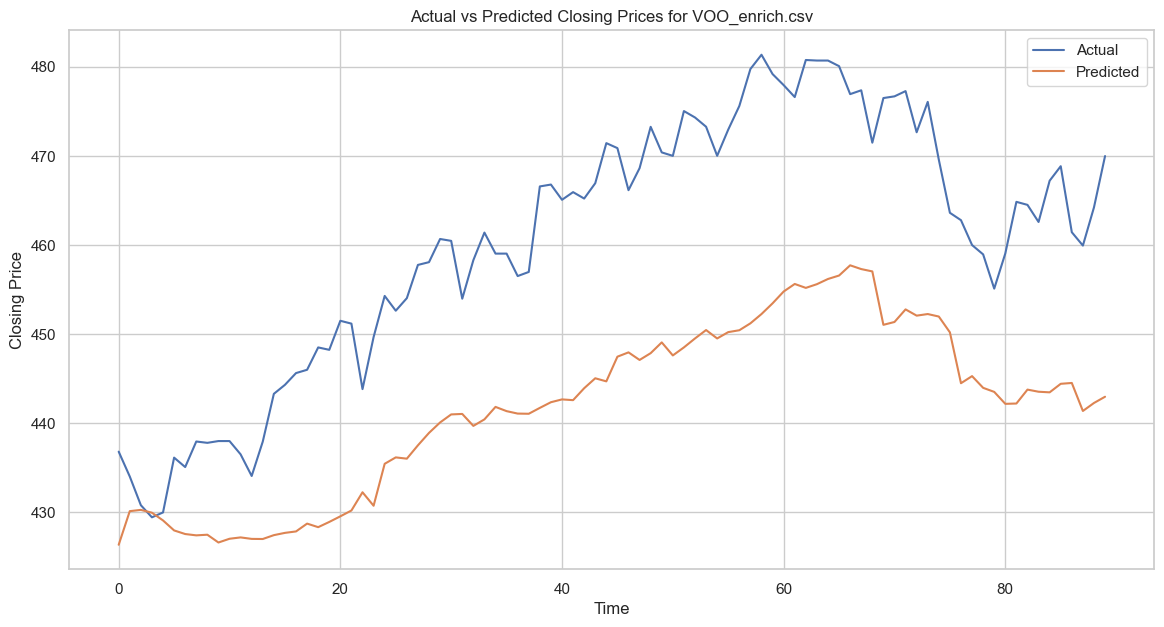

In [114]:
# Create sequences
X_seq, y_seq = create_sequences(X, y, time_steps)

# Split the dataset
test_days = 90
X_train, X_test = X_seq[:-test_days], X_seq[-test_days:]
y_train, y_test = y_seq[:-test_days], y_seq[-test_days:]

# Set seeds for reproducibility
seed = 2024
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# # Train the model
# history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

# Evaluate the model
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Inverse transform the predictions and the actual values
y_train_inv = scaler.inverse_transform(np.hstack((np.zeros((y_train.shape[0], X_train.shape[2])), y_train.reshape(-1, 1))))[:, -1]
y_test_inv = scaler.inverse_transform(np.hstack((np.zeros((y_test.shape[0], X_test.shape[2])), y_test.reshape(-1, 1))))[:, -1]

y_train_pred_inv = scaler.inverse_transform(np.hstack((np.zeros((y_train_pred.shape[0], X_train.shape[2])), y_train_pred)))[:, -1]
y_test_pred_inv = scaler.inverse_transform(np.hstack((np.zeros((y_test_pred.shape[0], X_test.shape[2])), y_test_pred)))[:, -1]

# Calculate RMSE and MAPE for training data
rmse_train = np.sqrt(mean_squared_error(y_train_inv, y_train_pred_inv))
mape_train = mean_absolute_percentage_error(y_train_inv, y_train_pred_inv)

# Calculate RMSE and MAPE for testing data
rmse_test = np.sqrt(mean_squared_error(y_test_inv, y_test_pred_inv))
mape_test = mean_absolute_percentage_error(y_test_inv, y_test_pred_inv)

print(f"Training RMSE: {rmse_train}")
print(f"Training MAPE: {mape_train}")
print(f"Testing RMSE: {rmse_test}")
print(f"Testing MAPE: {mape_test}")

# Plot the actual vs. predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_test_pred_inv, label='Predicted')
plt.title(f'Actual vs Predicted Closing Prices for {ticker}')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

c:\Users\KUNAL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


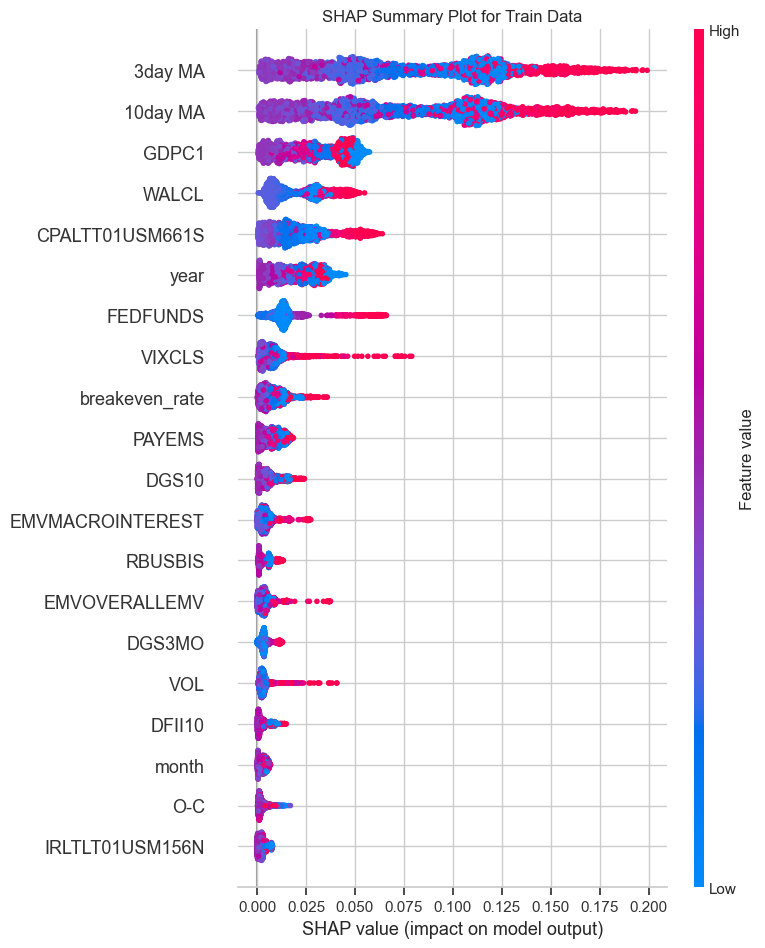

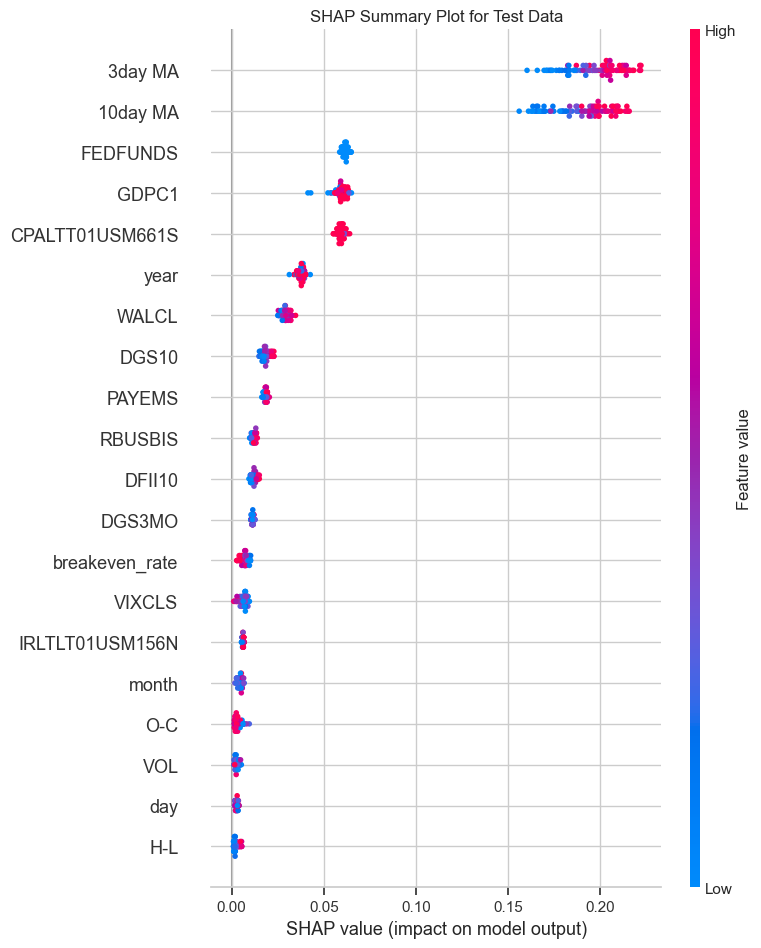

In [115]:
import shap
# Create an explainer
explainer = shap.GradientExplainer(model, X_train)
# Compute SHAP values for the training and test sets
shap_values_train = explainer.shap_values(X_train)
shap_values_test = explainer.shap_values(X_test)

# Set seeds for reproducibility
seed = 2024
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Ensure that the SHAP library is initialized
shap.initjs()

# Aggregate SHAP values over time steps by summing absolute values
shap_values_train_aggregated = np.sum(np.abs(shap_values_train), axis=1).reshape(X_train.shape[0], -1)
shap_values_test_aggregated = np.sum(np.abs(shap_values_test), axis=1).reshape(X_test.shape[0], -1)

# Aggregate the corresponding features by taking the mean across time steps
X_train_aggregated = np.mean(X_train, axis=1)
X_test_aggregated = np.mean(X_test, axis=1)

# Plot the summary plot for feature importance (Train Data)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_train_aggregated, features=X_train_aggregated, feature_names=features, show=False)
plt.title('SHAP Summary Plot for Train Data')
plot_filename = f'{os.path.splitext(ticker)[0]}_SHAPSummaryTrain_performance_plot.png'
plt.savefig(plot_filename)
plt.show()
plt.close()

# Plot the summary plot for feature importance (Test Data)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_test_aggregated, features=X_test_aggregated, feature_names=features, show=False)
plt.title('SHAP Summary Plot for Test Data')
plot_filename = f'{os.path.splitext(ticker)[0]}_SHAPSummaryTest_performance_plot.png'
plt.savefig(plot_filename)
plt.show()
plt.close()

1/1 [==============================] - 0s 19ms/step


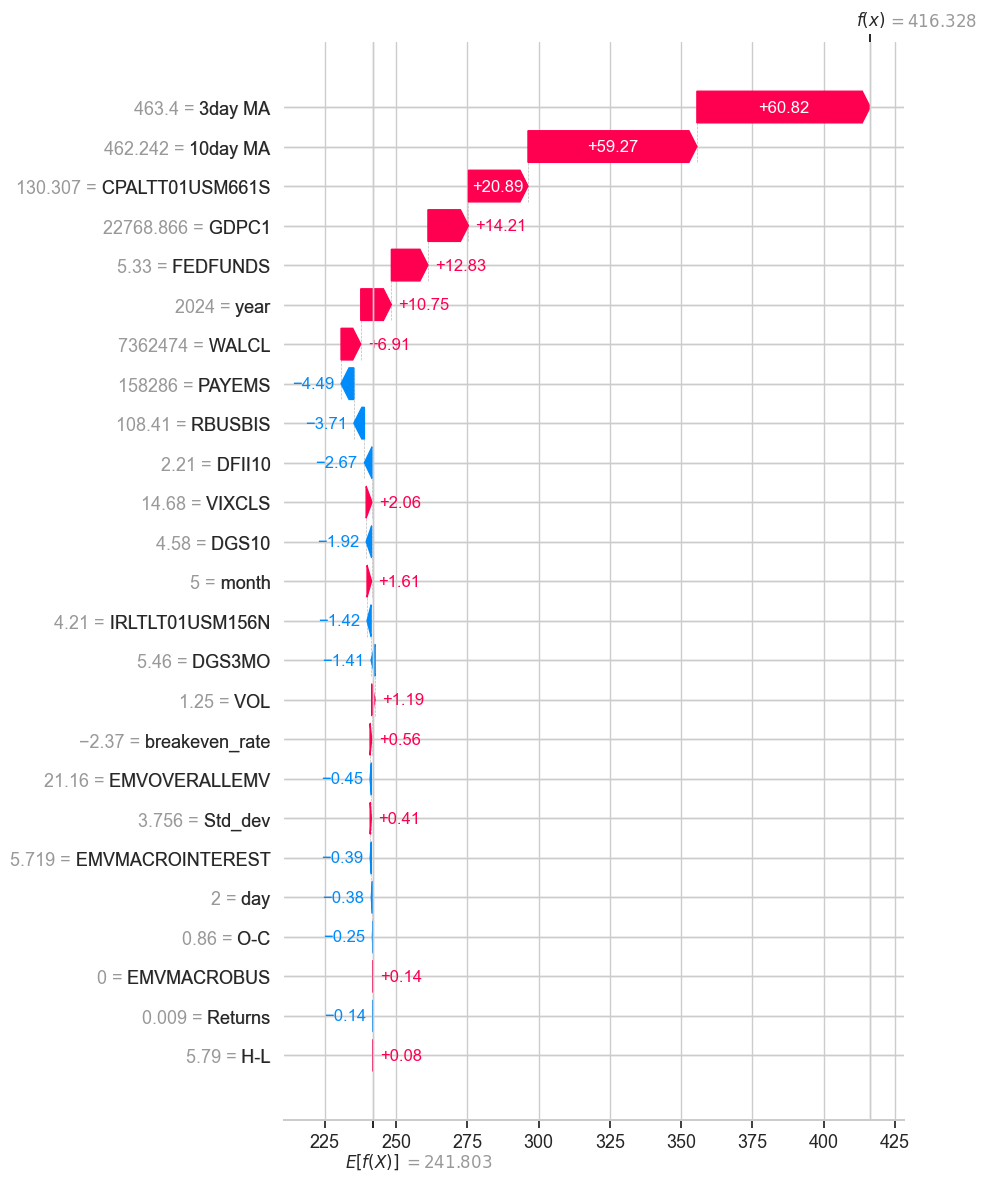

In [116]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Assuming the last observation from X_test is what you want to explain
# Sum the SHAP values across all time steps for each feature
shap_values_last_obs = shap_values_test[0].sum(axis=0).flatten()  # Summing across the time steps and flattening

# Ensure the SHAP values are a 1D array (for a single output model)
if len(shap_values_last_obs.shape) > 1:
    shap_values_last_obs = shap_values_last_obs[:, 0]  # Take the first output if there's more than one

# Extract the feature values for the last observation
data_last_time_step = X_test[-1, :, :]  # Most recent time step's feature values

# Reshape the last observation to match the input shape required by LSTM
last_observation_reshaped = data_last_time_step.reshape(1, data_last_time_step.shape[0], data_last_time_step.shape[1])

# Inverse transform the feature values to get them back to their original scale
full_feature_row = np.zeros((1, len(features) + 1))
full_feature_row[0, :-1] = last_observation_reshaped[0, -1, :]
full_feature_row_unscaled = scaler.inverse_transform(full_feature_row)
data_last_time_step_unscaled = full_feature_row_unscaled[0, :-1]  # Remove the appended zero for the target

# Compute the expected value manually on scaled data
expected_value_scaled = model.predict(X_train).mean()

# Unscale the expected value
expected_value_unscaled = scaler.inverse_transform([[0] * len(features) + [expected_value_scaled]])[0, -1]

# Adjust SHAP values to match the unscaled values
shap_values_last_obs_unscaled = shap_values_last_obs * scaler.data_range_[-1]  # Rescale SHAP values based on the target variable's range

# Predict the unscaled value for the last observation
last_observation_prediction = model.predict(last_observation_reshaped)
last_observation_prediction_unscaled = scaler.inverse_transform([[0] * len(features) + [last_observation_prediction[0, 0]]])[0, -1]

# Set up the figure size before creating the SHAP plot
plt.figure(figsize=(10, 6))

# Create the SHAP waterfall plot with unscaled data
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_last_obs_unscaled,  # Unscaled SHAP values for the last observation
        base_values=expected_value_unscaled,  # Unscaled base value
        data=data_last_time_step_unscaled,  # Unscaled feature values for the last time step
        feature_names=features  # List of feature names
    ),
    max_display=len(features),
    show=False  # Disable automatic display
)

# Save the plot with a proper resolution
plot_filename = f'{os.path.splitext(ticker)[0]}_SHAPWaterfall_performance_plot.png'
plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
plt.show()
plt.close()


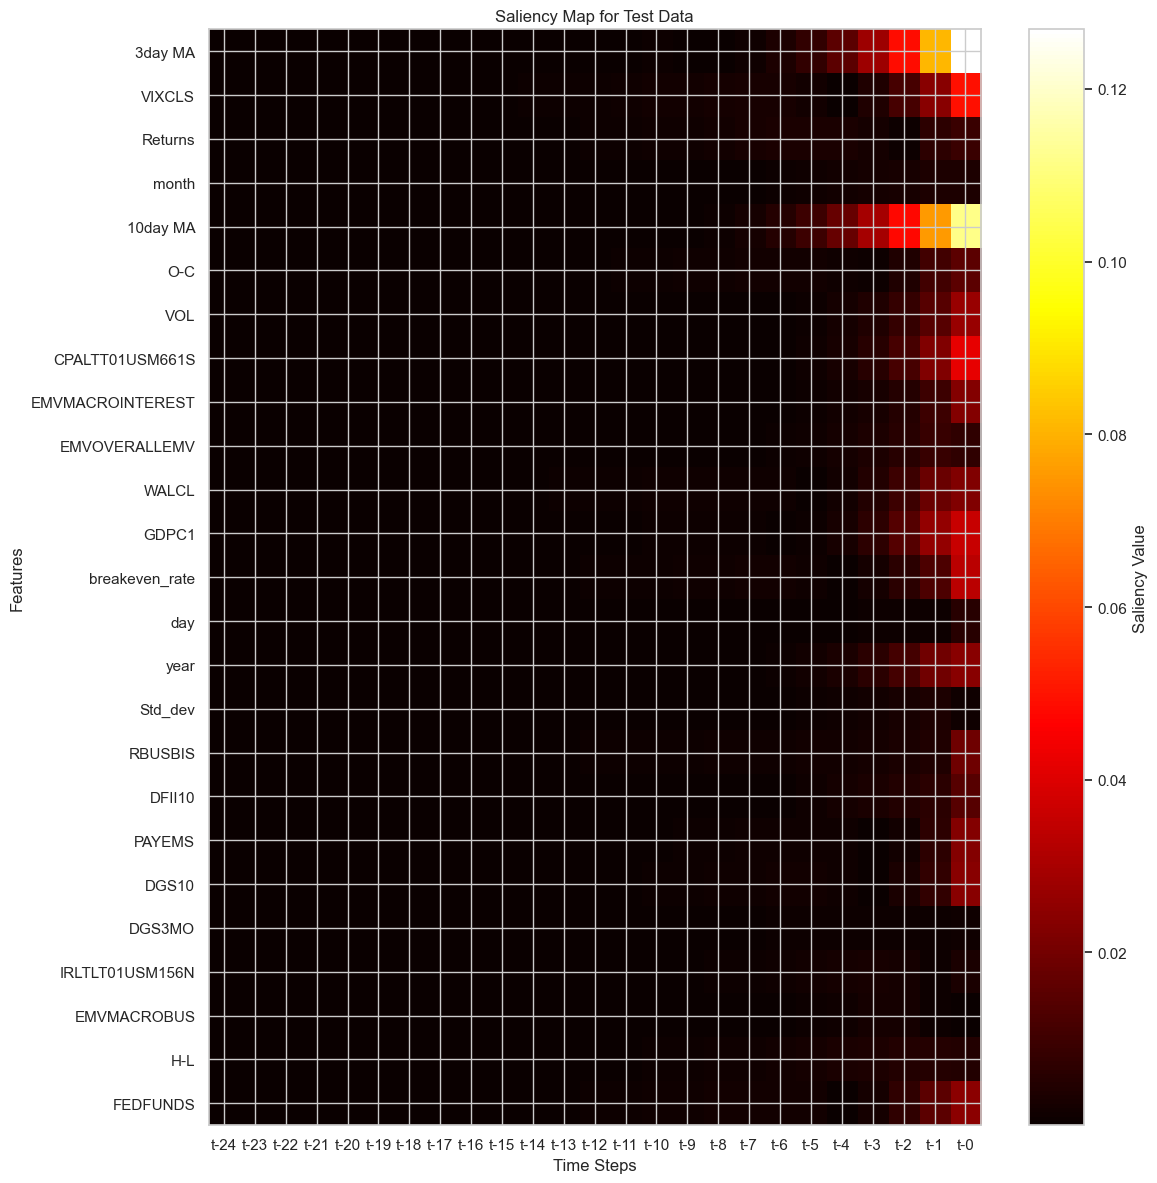

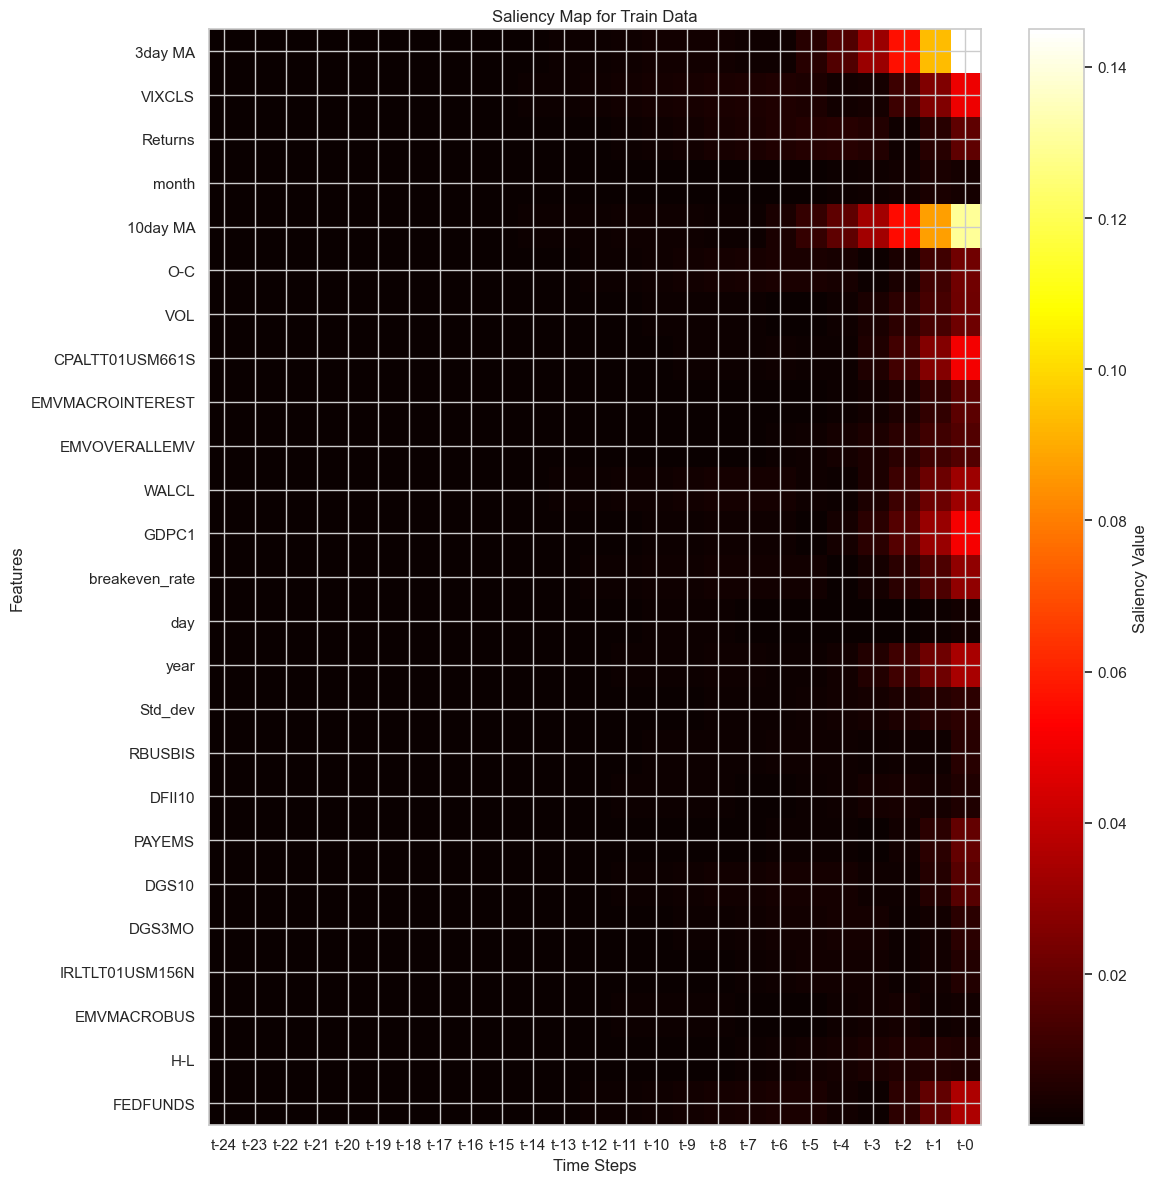

In [117]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Convert numpy arrays to tensors
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)

# Function to compute saliency map
def compute_saliency_map(model, X):
    with tf.GradientTape() as tape:
        tape.watch(X)
        predictions = model(X)
    gradients = tape.gradient(predictions, X)
    return tf.abs(gradients).numpy()

# Compute saliency maps for test and train data
saliency_maps_test = compute_saliency_map(model, X_test_tensor)
saliency_maps_train = compute_saliency_map(model, X_train_tensor)

def plot_saliency_map(saliency_map, feature_names, title="Saliency Map"):
    mean_saliency_map = np.mean(saliency_map, axis=0)  # Average over samples
    plt.figure(figsize=(12, 12))
    plt.imshow(mean_saliency_map.T, cmap='hot', interpolation='nearest', aspect='auto')
    plt.colorbar(label='Saliency Value')
    plt.title(title)
    plt.xlabel('Time Steps')
    plt.ylabel('Features')
    plt.xticks(ticks=np.arange(saliency_map.shape[1]), labels=[f't-{i}' for i in range(saliency_map.shape[1]-1, -1, -1)])
    plt.yticks(ticks=np.arange(len(feature_names)), labels=feature_names)
    plt.tight_layout()

# Plot saliency map for the test data
plot_saliency_map(saliency_maps_test, features, title="Saliency Map for Test Data")
plot_filename = f'{os.path.splitext(ticker)[0]}_SaliencyTest_plot.png'
plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# Plot saliency map for the train data
plot_saliency_map(saliency_maps_train, features, title="Saliency Map for Train Data")
plot_filename = f'{os.path.splitext(ticker)[0]}_SaliencyTrain_plot.png'
plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
plt.show()
plt.close()


3/3 [==============================] - 0s 7ms/step


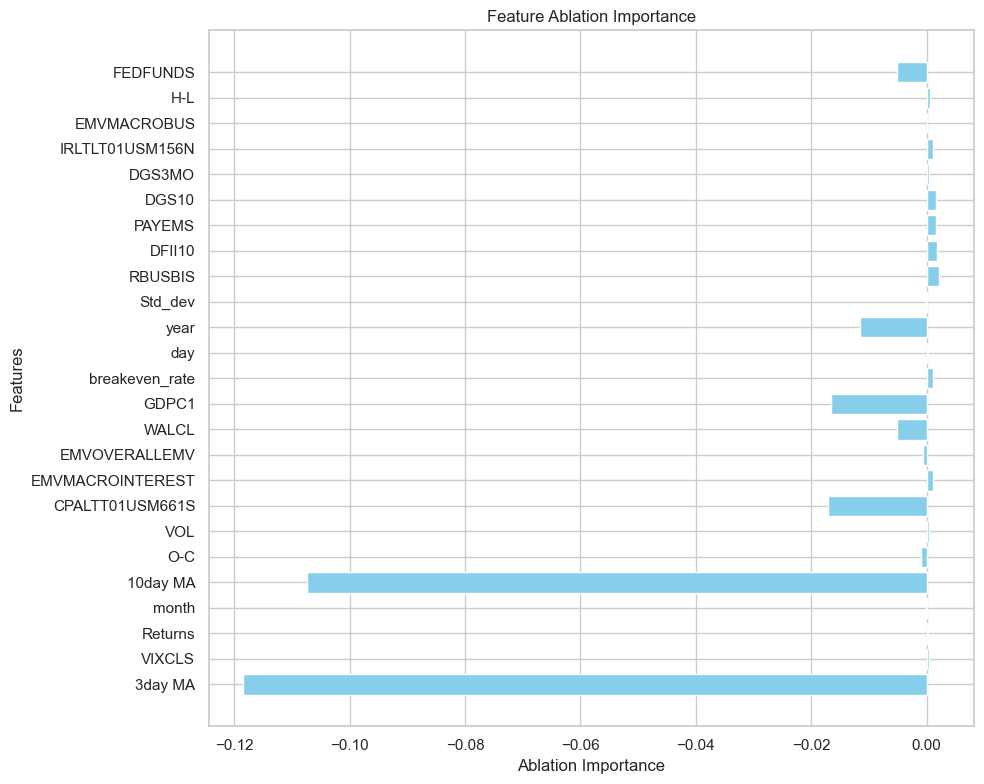

In [118]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def feature_ablation(model, X, y, feature_names, plot_filename):
    base_score = mean_squared_error(y, model.predict(X))
    scores = []

    for i in range(X.shape[-1]):
        X_ablated = X.copy()
        X_ablated[:, :, i] = 0  # Ablate the feature
        score = mean_squared_error(y, model.predict(X_ablated))
        scores.append(base_score - score)

    # Plotting
    plt.figure(figsize=(10, 8))
    plt.barh(feature_names, scores, color='skyblue')
    plt.xlabel('Ablation Importance')
    plt.ylabel('Features')
    plt.title('Feature Ablation Importance')
    plt.tight_layout()

    # Save the plot before showing it
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# Compute feature ablation scores with actual feature names
plot_filename = f'{os.path.splitext(ticker)[0]}_FeatureAblation_plot.png'
feature_ablation(model, X_test, y_test, features, plot_filename)

In [119]:
import lime
import lime.lime_tabular
from sklearn.tree import DecisionTreeRegressor
import numpy as np
import matplotlib.pyplot as plt

# Aggregate the training data over time steps by averaging
X_train_aggregated = np.mean(X_train, axis=1)

# Define the LIME explainer using aggregated training data
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_aggregated,
    training_labels=y_train,
    feature_names=features,
    class_names=['Price'],
    mode='regression'
)

# Extract the last sequence from the test data and scale it
last_observation = X_test[-1].reshape(1, time_steps, X_train.shape[2])
last_sequence_aggregated = np.mean(last_observation, axis=1).reshape(1, -1)

# Define a function for LIME to use the decision tree as a surrogate model
def predict_with_surrogate(data):
    surrogate_model = DecisionTreeRegressor()
    surrogate_model.fit(X_train_aggregated, y_train)
    return surrogate_model.predict(data)

# Compute LIME explanations for the last instance
exp = explainer_lime.explain_instance(last_sequence_aggregated[0], predict_with_surrogate, num_features=10)

# Calculate the LIME prediction in the original scale
lime_prediction_scaled = exp.local_pred[0]
lime_prediction_original = (lime_prediction_scaled * (data['Close'].max() - data['Close'].min())) + data['Close'].min()

# Assume `future_actual` is the actual value you're comparing against
future_actual = data['Close'].iloc[-1]

# Calculate MAPE
mape = 100 * abs(future_actual - lime_prediction_original) / future_actual
mape_text = f'LIME MAPE: {mape:.2f}%'

# Create the plot using LIME's built-in method
fig = exp.as_pyplot_figure()
plt.title(f'Prediction: {lime_prediction_original:.2f} \n{mape_text}', fontsize=10)
plt.xlabel('Contribution to Prediction', fontsize=8)
plt.ylabel('Feature', fontsize=8)
plt.gcf().set_size_inches(7, 5.8)
plt.tight_layout()

# Save the plot before showing it
plot_filename = f'{os.path.splitext(ticker)[0]}_LIME.png'
plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
# plt.show()
plt.close()


In [120]:
print('xai complete.')

xai complete.
